In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [15]:
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_set, val_set = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

classes = train_data.classes

In [4]:
import torchvision.models as models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_vgg16_model():
    model = models.vgg16(pretrained=True)

    model.classifier[6] = nn.Linear(4096, 10)


    return model

In [5]:
model = get_vgg16_model().to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 192MB/s]


In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [7]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=5):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        accuracy = 100 * correct / total

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {accuracy:.2f}%")

    return train_losses, val_losses


In [8]:
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=5)

Epoch 1/5: 100%|██████████| 625/625 [10:48<00:00,  1.04s/it]


Epoch 1, Train Loss: 0.5412, Val Loss: 0.3268, Val Acc: 88.84%


Epoch 2/5: 100%|██████████| 625/625 [10:46<00:00,  1.03s/it]


Epoch 2, Train Loss: 0.2803, Val Loss: 0.2697, Val Acc: 90.94%


Epoch 3/5: 100%|██████████| 625/625 [10:47<00:00,  1.04s/it]


Epoch 3, Train Loss: 0.2103, Val Loss: 0.2597, Val Acc: 91.29%


Epoch 4/5: 100%|██████████| 625/625 [10:46<00:00,  1.04s/it]


Epoch 4, Train Loss: 0.1663, Val Loss: 0.2426, Val Acc: 92.14%


Epoch 5/5: 100%|██████████| 625/625 [10:46<00:00,  1.03s/it]


Epoch 5, Train Loss: 0.1386, Val Loss: 0.2747, Val Acc: 91.69%


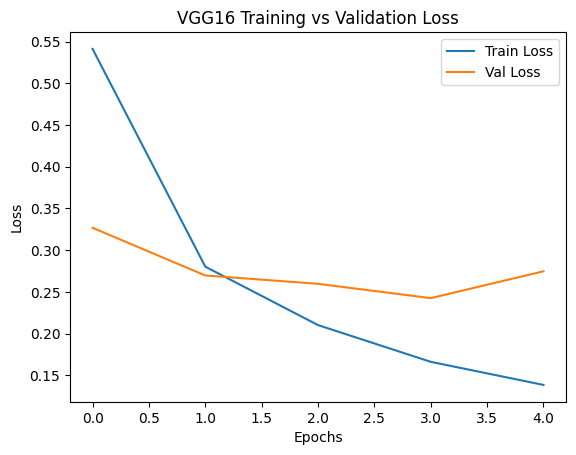

In [9]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("VGG16 Training vs Validation Loss")
plt.show()

In [11]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=test_data.classes))

In [12]:
evaluate_model(model, test_loader, device)

              precision    recall  f1-score   support

    airplane       0.97      0.85      0.91      1000
  automobile       0.92      0.98      0.95      1000
        bird       0.89      0.93      0.91      1000
         cat       0.92      0.75      0.83      1000
        deer       0.94      0.93      0.93      1000
         dog       0.82      0.93      0.87      1000
        frog       0.96      0.93      0.94      1000
       horse       0.96      0.94      0.95      1000
        ship       0.89      0.97      0.93      1000
       truck       0.93      0.95      0.94      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



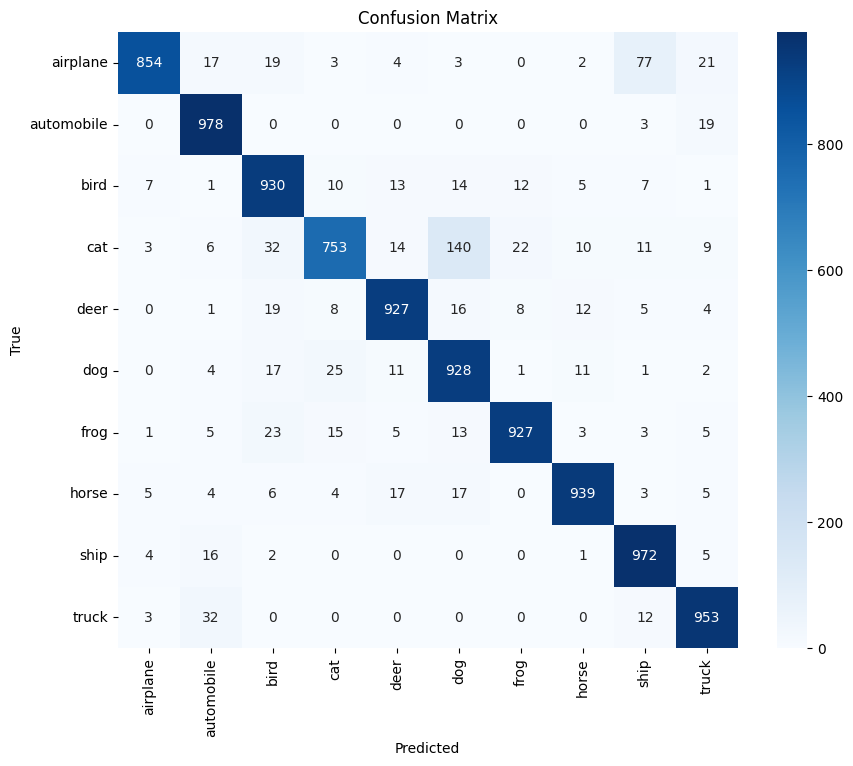

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(true, pred, classes):
    cm = confusion_matrix(true, pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

from sklearn.metrics import confusion_matrix

def get_preds_labels(model, loader):
    model.eval()
    preds = []
    labels = []

    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            output = model(imgs)
            _, pred = torch.max(output, 1)
            preds += pred.cpu().numpy().tolist()
            labels += lbls.numpy().tolist()

    return preds, labels

preds, labels = get_preds_labels(model, test_loader)
plot_confusion_matrix(labels, preds, test_data.classes)

In [16]:
def get_probs_labels(model, dataloader):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_probs), np.array(all_labels)

probs, labels = get_probs_labels(model, test_loader)
labels_bin = label_binarize(labels, classes=list(range(10)))

auc_scores = []
for i in range(10):
    auc = roc_auc_score(labels_bin[:, i], probs[:, i])
    auc_scores.append(auc)

for i, score in enumerate(auc_scores):
    print(f"Class {i} ({classes[i]}): ROC-AUC = {score:.4f}")

print(f"\nAverage ROC-AUC: {np.mean(auc_scores):.4f}")

Class 0 (airplane): ROC-AUC = 0.9962
Class 1 (automobile): ROC-AUC = 0.9982
Class 2 (bird): ROC-AUC = 0.9950
Class 3 (cat): ROC-AUC = 0.9893
Class 4 (deer): ROC-AUC = 0.9970
Class 5 (dog): ROC-AUC = 0.9932
Class 6 (frog): ROC-AUC = 0.9981
Class 7 (horse): ROC-AUC = 0.9980
Class 8 (ship): ROC-AUC = 0.9982
Class 9 (truck): ROC-AUC = 0.9967

Average ROC-AUC: 0.9960


In [17]:
def get_vgg19_model():
    model = models.vgg19(pretrained=True)  # load pretrained weights
    model.classifier[6] = nn.Linear(4096, 10)  # change output layer for CIFAR-10 (10 classes)
    return model.to(device)

In [19]:
model = get_vgg19_model()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 119MB/s]


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [22]:
vgg19_model = models.vgg19(pretrained=True)

for param in vgg19_model.parameters():
    param.requires_grad = False

vgg19_model.classifier[6] = nn.Linear(4096, 10)


for param in vgg19_model.classifier[6].parameters():
    param.requires_grad = True

vgg19_model = vgg19_model.to(device)

criterion = nn.CrossEntropyLoss()
vgg19_optimizer = optim.SGD(filter(lambda p: p.requires_grad, vgg19_model.parameters()), lr=0.001, momentum=0.9)

num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    vgg19_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        vgg19_optimizer.zero_grad()
        outputs = vgg19_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        vgg19_optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    vgg19_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg19_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


Epoch [1/10] Train Loss: 1.2793 | Val Loss: 1.0040
Epoch [2/10] Train Loss: 1.0813 | Val Loss: 0.9348
Epoch [3/10] Train Loss: 1.0437 | Val Loss: 0.9084
Epoch [4/10] Train Loss: 1.0247 | Val Loss: 0.8933
Epoch [5/10] Train Loss: 1.0080 | Val Loss: 0.8714
Epoch [6/10] Train Loss: 0.9940 | Val Loss: 0.8483
Epoch [7/10] Train Loss: 0.9931 | Val Loss: 0.8586
Epoch [8/10] Train Loss: 0.9837 | Val Loss: 0.8487
Epoch [9/10] Train Loss: 0.9807 | Val Loss: 0.8420
Epoch [10/10] Train Loss: 0.9693 | Val Loss: 0.8351


In [23]:
# Evaluate on Test Set
vgg19_model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg19_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"VGG19 Test Accuracy: {100 * correct / total:.2f}%")


VGG19 Test Accuracy: 75.39%


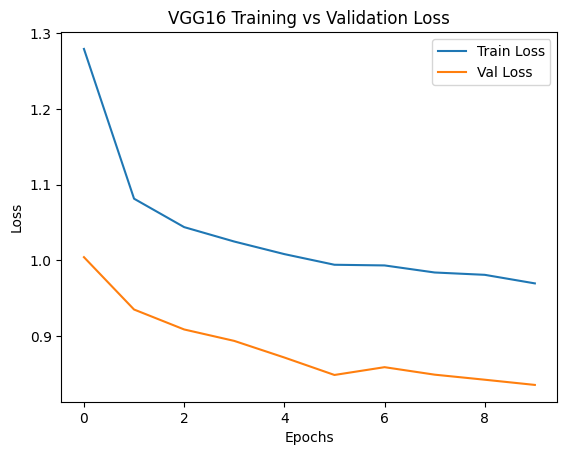

In [26]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("VGG16 Training vs Validation Loss")
plt.show()

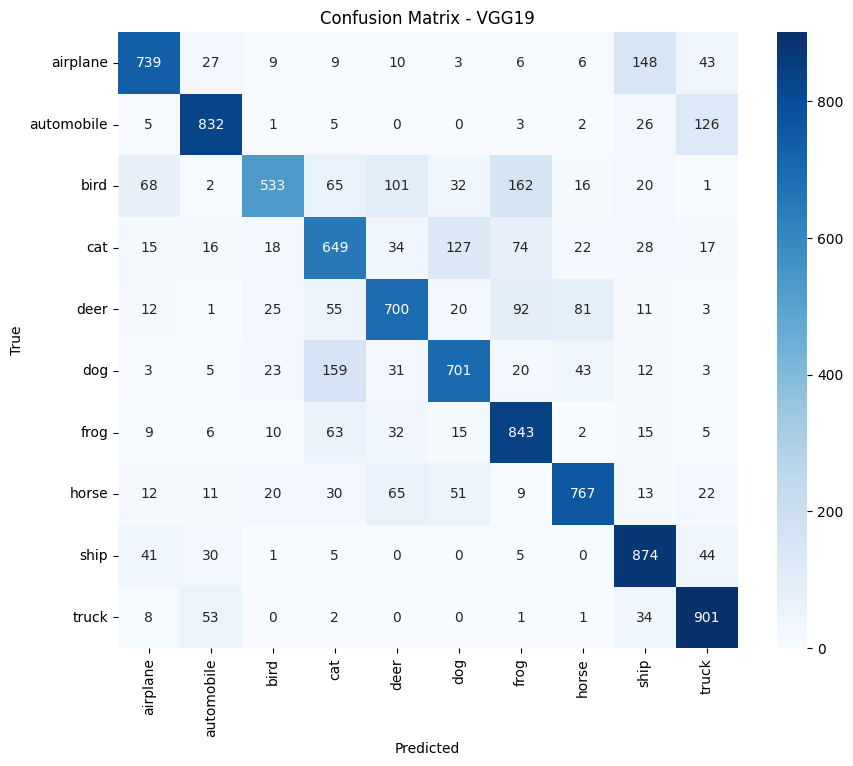

In [25]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - VGG19')
plt.show()